# **Visión por computador profunda mediante redes neuronales convolucionales**

Aunque el superordenador Deep Blue de IBM derrotó al campeón de ajedrez Garry Kasparov  en 1996, hasta hace bastante poco los ordenadores no eran capaces de realizar de manera  fiable tareas aparentemente triviales, como detectar un cachorro en una imagen o reconocer  palabras habladas. ¿Por qué esas tareas no nos cuestan ningún esfuerzo a los humanos? La  respuesta está en el hecho de que la percepción se produce mayormente fuera del territorio de  la consciencia, dentro de módulos especializados visuales, auditivos y relativos a otros sentidos  en nuestro cerebro. Para cuando la información sensorial llega a nuestra consciencia, ya está  adornada con características de alto nivel; por ejemplo, cuando vemos una foto de un hermoso  cachorrito, no podemos elegir no ver el cachorro o no notar lo mono que es. Tampoco podemos  explicar cómo reconocemos un cachorrito; nos resulta obvio. Por tanto, no podemos confiar  en nuestra experiencia subjetiva: la percepción no es trivial en absoluto y, para entenderlo,  debemos fijarnos en cómo funcionan nuestros módulos sensoriales.  Las redes neuronales convolucionales (RNC) surgieron del estudio de la corteza visual del  cerebro y se utilizan en el reconocimiento de imágenes por ordenador desde los 80. En los  últimos 10 años, gracias al aumento de la potencia computacional, la cantidad de datos de  entrenamiento disponibles y los trucos presentados en el capítulo 11 para el entrenamiento  de redes profundas, las RNC han logrado alcanzar un rendimiento sobrehumano en algunas  tareas visuales complejas. Están detrás de los servicios de búsqueda de imágenes, los coches  autónomos, los sistemas de clasificación automáticos, etc. Además, las RNC no se restringen  a la percepción visual: también tienen éxito en muchas otras tareas, como el reconocimiento  de voz y el procesamiento del lenguaje natural. Sin embargo, vamos a centrarnos en las aplicaciones visuales por ahora. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Convolutional Layers

El bloque de construcción más importante de una RNC es la capa convolucional:6 las neuronas de la primera capa convolucional no están conectadas a todos y cada uno de los píxeles  de la imagen de entrada (como estaban en las capas que hemos visto en otros capítulos), sino solo a píxeles en sus campos receptivos (véase la figura 14.2). A su vez, cada neurona de la  segunda capa convolucional está conectada solo a las neuronas ubicadas dentro de un rectángulo pequeño en la primera capa. Esta arquitectura permite a la red concentrarse en características pequeñas de bajo nivel en la primera capa oculta, juntarlas después para crear  características más grandes de nivel superior en la siguiente capa oculta, y así sucesivamente.  Esta estructura jerárquica es común en imágenes del mundo real, que es una de las razones  por las que las RNC funcionan tan bien para el reconocimiento de imágenes.

## Implementación de capas convolucionales con Keras

Carguemos dos imágenes de ejemplo, reescalemos sus valores de píxel a 0-1 y recórtemoslas por el centro para convertirlas en pequeñas imágenes de 70×120:

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [4]:
images.shape

TensorShape([2, 70, 120, 3])

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [6]:
fmaps.shape

TensorShape([2, 64, 114, 32])

In [7]:
# muestra los dos mapas de características de salida para cada imagen

# plt.figure(figsize=(15, 9))
# for image_idx in (0, 1):
#     for fmap_idx in (0, 1):
#         plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
#         plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
#         plt.axis("off")

# plt.show()

Como puedes ver, los filtros generados aleatoriamente suelen actuar como detectores de bordes, lo cual es estupendo ya que se trata de una herramienta útil en el procesamiento de imágenes, y ese es el tipo de filtros con el que suele empezar una capa convolucional. Luego, durante el entrenamiento, aprende gradualmente filtros mejorados para reconocer patrones útiles para la tarea.

Ahora vamos a utilizar el relleno cero:

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [10]:
# muestra que la forma de salida cuando fijamos strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [11]:
# esta función de utilidad puede ser útil para calcular el tamaño de los
# mapas de características producidos por una capa convolucional. También devuelve
# el número de filas o columnas ignoradas si padding="valid", o el
# número de filas o columnas con relleno cero si padding="same"."""

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Veamos ahora los pesos:

In [12]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [13]:
biases.shape

(32,)

In [14]:
# muestra cómo utilizar la operación tf.nn.conv2d()

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Creemos manualmente dos filtros llenos de ceros, excepto una línea vertical de 1s en el primer filtro, y una horizontal en el segundo filtro. Los dos mapas de características de salida resaltan las líneas verticales y las líneas horizontales, respectivamente. En la práctica, es probable que nunca necesite crear filtros manualmente, ya que las capas convolucionales los aprenderán automáticamente.

In [15]:
# muestra cómo crear manualmente dos filtros para obtener imágenes similares
# a las anteriores.

# plt.figure(figsize=(15, 9))
# filters = np.zeros([7, 7, 3, 2])
# filters[:, 3, :, 0] = 1
# filters[3, :, :, 1] = 1
# fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

# for image_idx in (0, 1):
#     for fmap_idx in (0, 1):
#         plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
#         plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
#         plt.axis("off")

# plt.show()

¿Notas las líneas oscuras en la parte superior e inferior de las dos imágenes de la izquierda, y en la izquierda y derecha de las dos imágenes de la derecha? ¿Puedes adivinar de qué se trata? ¿Por qué no estaban presentes en la figura anterior?

Lo has adivinado. Se trata de artefactos debidos al hecho de que en este caso utilizamos relleno cero, mientras que en la figura anterior no utilizamos relleno cero para crear los mapas de características. Debido al relleno cero, los dos mapas de características basados en el filtro de línea vertical (es decir, las dos imágenes de la izquierda) no pudieron activarse completamente cerca de la parte superior e inferior de las imágenes. Del mismo modo, los dos mapas de características basados en el filtro de línea horizontal (es decir, las dos imágenes de la derecha) no podían activarse completamente cerca de la izquierda y la derecha de las imágenes.

# Pooling Layers
## Implementación de capas de agrupación con Keras

**Max pooling**

In [16]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [17]:
output = max_pool(images)

In [18]:
# estas celdas muestran como se ve max pooling con stride = 2

# import matplotlib as mpl

# fig = plt.figure(figsize=(12, 8))
# gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

# ax1 = fig.add_subplot(gs[0, 0])
# ax1.set_title("Input")
# ax1.imshow(images[0])  # trazar la 1ª imagen
# ax1.axis("off")
# ax2 = fig.add_subplot(gs[0, 1])
# ax2.set_title("Output")
# ax2.imshow(output[0])  # trazar la salida para la 1ª imagen
# ax2.axis("off")
# plt.show()

**Depth-wise pooling**

In [19]:
# muestra cómo usar la opción max_pool(); sólo funciona en la CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [20]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] es el número de canales
        groups = shape[-1] // self.pool_size  # número de grupos de canales
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [21]:
# muestra que esta capa personalizada da el mismo resultado que max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

In [22]:
# calcula y muestra la salida de la capa de agrupación en profundidad

# depth_output = DepthPool(pool_size=3)(images)

# plt.figure(figsize=(12, 8))
# plt.subplot(1, 2, 1)
# plt.title("Input")
# plt.imshow(images[0])  # trazar la 1ª imagen
# plt.axis("off")
# plt.subplot(1, 2, 2)
# plt.title("Output")
# plt.imshow(depth_output[0, ..., 0], cmap="gray")  # trazar la salida de la primera imagen
# plt.axis("off")
# plt.show()

**Global Average Pooling**

In [23]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

La siguiente capa es equivalente:

In [24]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [25]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN Architectures

**Abordar la moda MNIST con una CNN**

In [26]:
# carga el conjunto de datos mnist, añade el eje channels a las entradas,
# escala los valores al rango 0-1, y divide el conjunto de datos
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [27]:
from functools import partial

tf.random.set_seed(42)  # garantiza la reproducibilidad
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

c:\Users\Abdon.RAMIREZ-BRICEN\OneDrive - Akkodis\Documents\DS102024_NEW\3-MachineLearning\7-DeepLearning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# compila, ajusta, evalúa y utiliza el modelo para hacer predicciones
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# history = model.fit(X_train, y_train, epochs=10,
#                     validation_data=(X_valid, y_valid))
# score = model.evaluate(X_test, y_test)
# X_new = X_test[:10]  # fingir que tenemos nuevas imágenes
# y_pred = model.predict(X_new)

## LeNet-5

La famosa arquitectura LeNet-5 tenía las siguientes capas:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

Hubo algunos retoques aquí y allá, que en realidad ya no importan mucho, pero por si te interesan, aquí están:

* Las imágenes MNIST tienen 28 × 28 píxeles, pero se les aplica un relleno cero de 32 × 32 píxeles y se normalizan antes de introducirlas en la red. El resto de la red no utiliza ningún relleno, por lo que el tamaño sigue reduciéndose a medida que la imagen avanza por la red.
* Las capas de agrupación de medias son algo más complejas de lo habitual: cada neurona calcula la media de sus entradas, luego multiplica el resultado por un coeficiente aprendible (uno por mapa) y añade un término de sesgo aprendible (de nuevo, uno por mapa), para finalmente aplicar la función de activación.
* La mayoría de las neuronas de los mapas C3 están conectadas a neuronas de sólo tres o cuatro mapas S2 (en lugar de los seis mapas S2). Para más detalles, véase la tabla 1 (página 8) del [documento original](https://homl.info/lenet5).
* La capa de salida es un poco especial: en lugar de calcular la multiplicación matricial de las entradas y el vector de pesos, cada neurona produce el cuadrado de la distancia euclidiana entre su vector de entrada y su vector de pesos. Cada salida mide en qué medida la imagen pertenece a una determinada clase de dígitos. Ahora se prefiere la función de coste de entropía cruzada, ya que penaliza mucho más las malas predicciones, produce gradientes mayores y converge más rápidamente.

# Implementación de una CNN ResNet-34 con Keras

In [29]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [30]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Uso de modelos preentrenados de Keras

In [31]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [32]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [33]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [34]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(2, 1000)

In [35]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03598930 - jigsaw_puzzle 30.68%
  n02782093 - balloon      17.17%
  n03888257 - parachute    5.57%
Image #1
  n04209133 - shower_cap   34.37%
  n09229709 - bubble       11.41%
  n02782093 - balloon      9.46%


In [36]:
# muestra las imágenes recortadas y redimensionadas

# plt.figure(figsize=(10, 6))
# for idx in (0, 1):
#     plt.subplot(1, 2, idx + 1)
#     plt.imshow(images_resized[idx] / 255)
#     plt.axis("off")

# plt.show()

# Modelos preentrenados para el aprendizaje por transferencia

In [37]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [38]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [39]:
dataset_size

3670

In [40]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [41]:
n_classes

5

In [42]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [43]:
# muestra las 9 primeras imágenes del conjunto de validación

# plt.figure(figsize=(12, 10))
# index = 0
# for image, label in valid_set_raw.take(9):
#     index += 1
#     plt.subplot(3, 3, index)
#     plt.imshow(image)
#     plt.title(f"Class: {class_names[label]}")
#     plt.axis("off")

# plt.show()

Los tres conjuntos de datos contienen imágenes individuales. Necesitamos agruparlas por lotes, pero para ello primero tenemos que asegurarnos de que todas tienen el mismo tamaño, o de lo contrario la agrupación por lotes no funcionará. Para ello podemos utilizar una capa `Resizing`. También debemos llamar a la función `tf.keras.applications.xception.preprocess_input()` para preprocesar las imágenes adecuadamente para el modelo Xception. También añadiremos shuffling y prefetching al conjunto de datos de entrenamiento.

In [44]:
tf.keras.backend.clear_session()  # reinicia el contador de nombres de capa

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Veamos de nuevo las 9 primeras imágenes del conjunto de validación: ahora son todas de 224x224, con valores que van de -1 a 1:

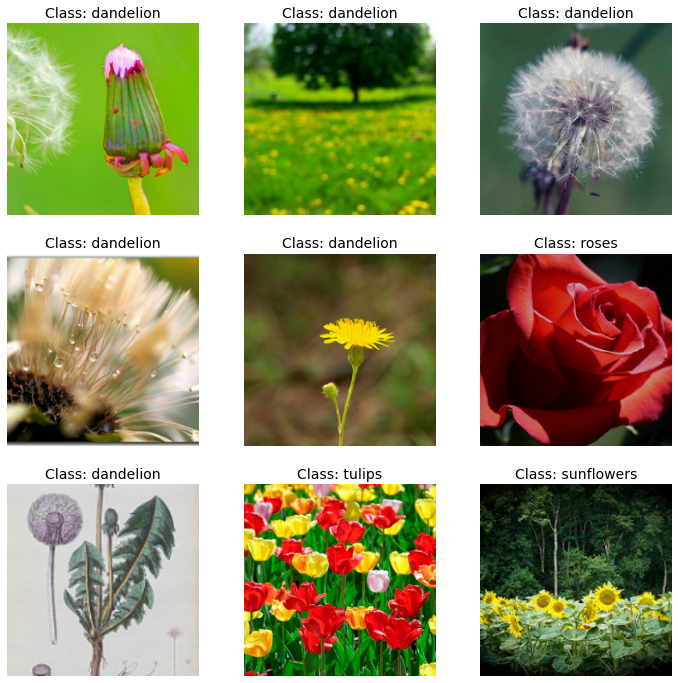

In [ ]:
# muestra las 9 primeras imágenes del primer lote de valid_set

# plt.figure(figsize=(12, 12))
# for X_batch, y_batch in valid_set.take(1):
#     for index in range(9):
#         plt.subplot(3, 3, index + 1)
#         plt.imshow((X_batch[index] + 1) / 2)  # reescala a 0-1 para imshow()
#         plt.title(f"Class: {class_names[y_batch[index]]}")
#         plt.axis("off")

# plt.show()

In [45]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

la siguiente celda varias veces para ver diferentes aumentos de datos aleatorios:

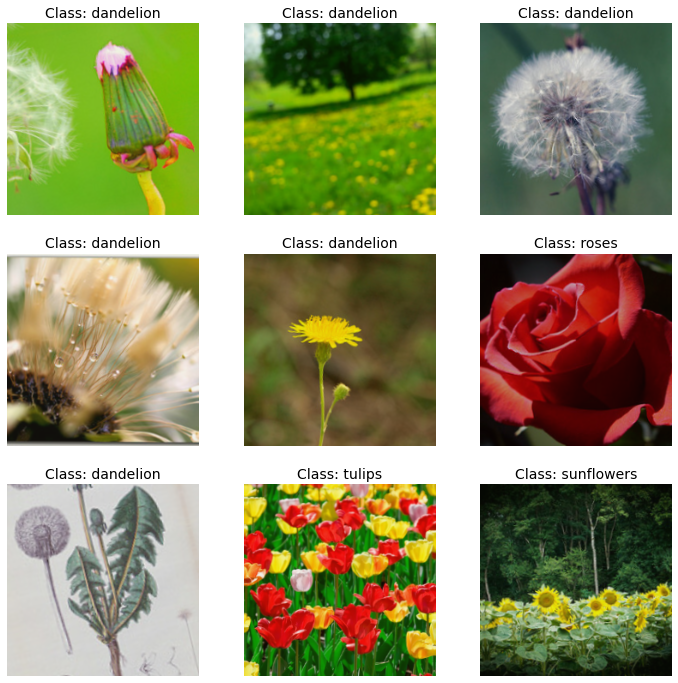

In [ ]:
# muestra las mismas 9 primeras imágenes, después del aumento

# plt.figure(figsize=(12, 12))
# for X_batch, y_batch in valid_set.take(1):
#     X_batch_augmented = data_augmentation(X_batch, training=True)
#     for index in range(9):
#         plt.subplot(3, 3, index + 1)
#         # Debemos reescalar las imágenes al rango 0-1 para imshow(), y también
#         # recortar el resultado a ese rango, porque el aumento de datos puede
#         # hacer que algunos valores se salgan de los límites (por ejemplo, RandomContrast en este caso).
#         plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
#         plt.title(f"Class: {class_names[y_batch[index]]}")
#         plt.axis("off")

# plt.show()

Ahora vamos a cargar el modelo preentrenado, sin sus capas superiores, y a sustituirlas por las nuestras, para la tarea de clasificación de flores:

In [46]:
tf.random.set_seed(42)  # garantiza la reproducibilidad
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [47]:
for layer in base_model.layers:
    layer.trainable = False

Entrenemos el modelo durante algunas épocas, manteniendo fijos los pesos del modelo base:

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3


86/86 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7317 - loss: 0.8539 - val_accuracy: 0.8603 - val_loss: 0.5901
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9120 - loss: 0.3274 - val_accuracy: 0.8203 - val_loss: 0.8332
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9273 - loss: 0.2579 - val_accuracy: 0.8512 - val_loss: 0.6269


In [49]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Ahora que los pesos de nuestras nuevas capas superiores no son tan malos, podemos hacer que la parte superior del modelo base sea entrenable de nuevo, y continuar entrenando, pero con una tasa de aprendizaje más baja:

In [54]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 72s 779ms/step - loss: 0.2921 - accuracy: 0.9117 - val_loss: 0.4541 - val_accuracy: 0.8711
Epoch 2/10
86/86 [==============================] - 67s 767ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.3715 - val_accuracy: 0.9074
Epoch 3/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.3679 - val_accuracy: 0.9038
Epoch 4/10
86/86 [==============================] - 67s 766ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.3298 - val_accuracy: 0.9020
Epoch 5/10
86/86 [==============================] - 67s 767ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.3876 - val_accuracy: 0.8984
Epoch 6/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.3708 - val_accuracy: 0.9038
Epoch 7/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.3535 - val_accuracy: 0.9147

# Clasificación y localización

In [55]:
tf.random.set_seed(42)  # garantiza la reproducibilidad
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depende de lo que más le interese
              optimizer=optimizer, metrics=["accuracy"])

In [56]:
#  ajusta el modelo utilizando cajas delimitadoras de objetivos aleatorios (en la vida real
# tendrías que crear objetivos adecuados en su lugar)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 22s 1s/step - loss: 1.2157 - dense_1_loss: 1.4583 - dense_2_loss: 0.2450 - dense_1_accuracy: 0.4219 - dense_2_accuracy: 0.2594
Epoch 2/2
10/10 [==============================] - 15s 1s/step - loss: 0.7974 - dense_1_loss: 0.9474 - dense_2_loss: 0.1972 - dense_1_accuracy: 0.7594 - dense_2_accuracy: 0.2812


# Relación entre el mAP y la precisión/recall

In [57]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

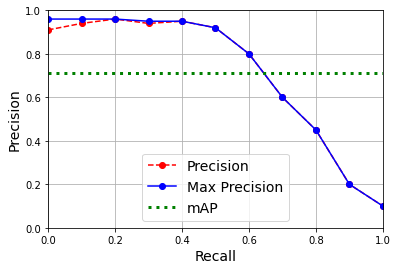

In [58]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()